In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

df_auto = pd.read_csv('http://bit.ly/1gIQs6C')

<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Линейные модели</center></h2>

## Quiz Time!

<center><img src='https://imgs.xkcd.com/comics/linear_regression.png'></center>

# Линейные модели

* Линейная регрессия
* Логистическая регрессия
* Метод опорных векторов (Support Vector Machine)


* *Обобщенные линейные модели
* *LDA (Linear Discriminant Analysis)



# Линейная регрессия

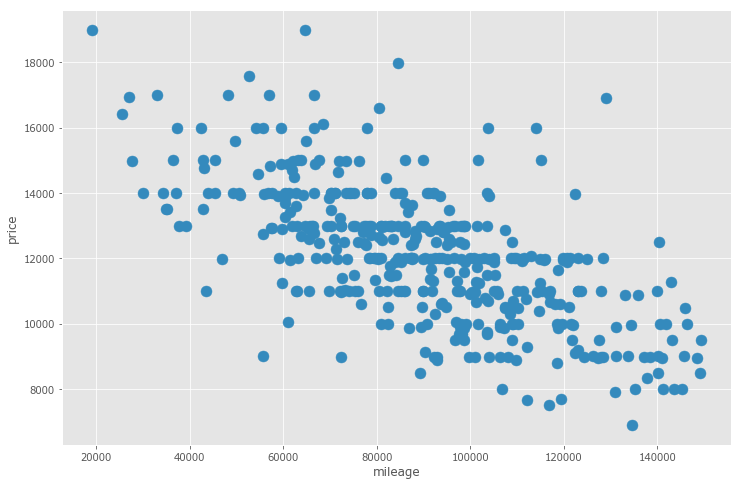

In [3]:
df_auto.plot(x='mileage', y='price', kind='scatter', s=120) 

# Постановка задачи

* Дано описание $n$ объектов по $m$ признакам в виде матрицы размера $n \times m$: $X = [x^{(i)}_j]^{i=1\dots n}_{j=1\dots m} $.<br\> ($x^{(i)}_j$ означает $j$-ый признак $i$-го объекта) <br\>
* Дана **вещественная** зависимая переменная, которая тоже имеет отношение к этим объекам: $y \in \mathbb{R}^n$

## Немного формул
Наша задача, выявить **линейную** зависимость между признаками в $X$ и значениями в $y$:
$$a(X) = \hat{y} = X\beta \quad \Leftrightarrow \quad a(x^{(i)}) = \hat{y}^{(i)} = \beta_0 + \beta_1x^{(i)}_1 + \dots$$
Необходимо оценить коэффициенты $\beta_i$.

В случае линейной регрессии коэффициенты $\beta_i$ рассчитываются так, чтобы минимизировать сумму квадратов ошибок по всем наблюдениям:
$$ L(\beta) = \frac{1}{2n}(\hat{y} - y)^{\top}(\hat{y} - y) = \frac{1}{2n}(X\beta - y)^{\top}(X\beta - y) \rightarrow \min\limits_{\beta} $$ $$ \Updownarrow $$  $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 + \dots - y^{(i)})^2  \rightarrow \min\limits_{\beta_i} $$

## Можно получить  решение аналитически

Пусть $a(x) = \beta_0 + \beta_1x_1$

Считаем частные производные по $\beta_0$, $\beta_1$, приравниваем к $0$, получаем нужные значения коэффициентов:

$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)}) = 0$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)} = 0$$

## Можно получить  решение аналитически

Можно обобщить на большее количество признаков и перевести в матричный вид:

$$ X^\top X\beta - X^\top y = 0 \quad \Leftrightarrow \quad \beta = (X^\top X)^{-1} X^\top y \quad\text{(Normal Equation)}$$

* [Matrix Calculus](http://eli.thegreenplace.net/2015/the-normal-equation-and-matrix-calculus/)
* [Matrix Cookbook](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf)

Почему так делать не стоит?
* Расчет обратной матрицы - дорогая и не совсем устойчивая операция (хотя бы потому что не у всякой матрицы есть обратная)
* Лучше будет воспользоваться методами оптимизации

# Градиентный спуск

In [2]:
from mpl_toolkits import mplot3d

def sq_loss_demo():

    beta0 = np.linspace(-8000, 6500, 100)
    beta1 = np.linspace(5000, 20000, 100)

    x = df_auto.loc[:, ['mileage']]
    x = (x-x.mean(axis=0))/x.std(axis=0)
    X = np.c_[x, np.ones(df_auto.shape[0])]


    B0, B1 = np.meshgrid(beta0, beta1)
    L = ((X.dot(np.r_[B0.reshape(1,-1), B1.reshape(1,-1)]) - df_auto.loc[:, 'price'].values.reshape(-1,1))**2).sum(axis=0)/(2*df_auto.shape[0])

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.view_init(40, 25)
    ax.plot_surface(B0, B1, L.reshape(B0.shape), alpha=0.3,)
    # ax.plot_(X, Y, Z)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')

    ax = fig.add_subplot(1, 2, 2)
    contour = ax.contour(B0, B1, L.reshape(B0.shape),)
    plt.clabel(contour, inline=1, fontsize=10)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    
    plt.show()

## Градиентный спуск

$$ L(\beta_0, \beta_1) = \frac{1}{2n}\sum_{i=1}^n(\beta_0 + \beta_1x_1^{(i)} - y^{(i)})^2$$ 

* Предположим мы выбрали какое-то начальное приближение $(\hat{\beta_0}, \hat{\beta_1})$
* Его можно постараться улучшить - надо двигаться в сторону наискорейшего убывания функции (Антиградиента!)

/home/lexa/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


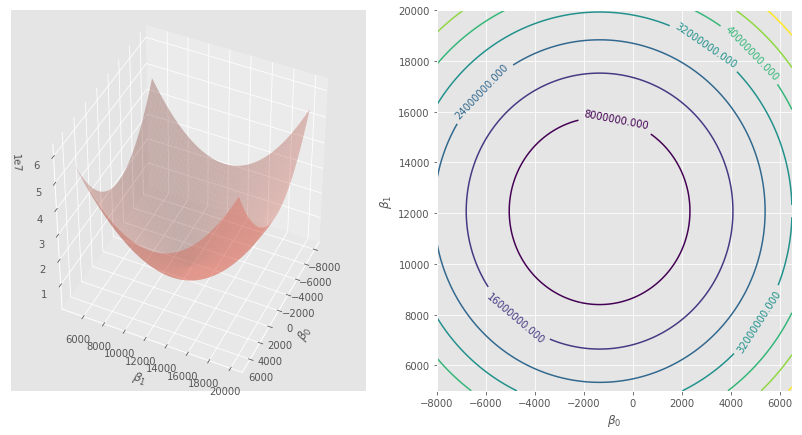

In [3]:
sq_loss_demo()

## Tiny Refresher

Производная функции $f(x)$ в точке $f(x_0)$:
$$ f'(x_0) = \lim\limits_{h \rightarrow 0}\frac{f(x_0+h) - f(x_0)}{h}$$

Производная  равна углу наклона касательной в точке $x_0$

In [6]:
def deriv_demo(h, x0):

    x = np.linspace(0.01, 20, 100)
    f = lambda x: np.sin(x)/x

    deriv = (f(x0+h) - f(x0))/h

    tang = lambda x:  f(x0) + deriv*(x - x0)
    
    plt.plot(x, f(x), label='$f(x)$')
    ylim = plt.ylim()

    plt.plot(x,tang(x), label='tangent line (deriv = %f)'%deriv)

    plt.scatter(x0, f(x0), marker='s', s=100)
    plt.scatter(x0+h, f(x0+h), marker='s', s=100)

    plt.ylim(ylim)
    
    plt.legend()
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    
    plt.show()


In [7]:
interact(deriv_demo, h=FloatSlider(min=0.0001, max=2, step=0.005), x0=FloatSlider(min=1, max=15, step=.2))

A Jupyter Widget

<function __main__.deriv_demo>

## Tiny Refresher

* Находим экстремум
* Если точка $x_0$ - экстремум функции, и в ней существует производная то $f'(x_0) = 0$
* Что если экстремумов много?

* Нам повезло, ведь функция ошибки линейной регрессии - выпуклая функция.
* Локальный экстремум выпуклой функции = глобальному экстремому

## Tiny Refresher

* В многомерном случае все обобщается и переходят к производным по направлению и градиенту:
$$ f'_v(x_0) = \lim\limits_{h \rightarrow 0}\frac{f(x_0+hv) - f(x_0)}{h} = \frac{d}{dh}f(x_{0,1} + hv_1, \dots, x_{0,d} + hv_d) \rvert_{h=0}, \quad ||v|| = 1 \quad \text{Производная по направлению}$$


$$ \frac{ \partial f(x_1,x_2,\dots,x_d)}{\partial x_i} = \lim\limits_{h \rightarrow 0}\frac{f(x_1, x_2, \dots, x_i + h, \dots, x_d) - f(x_1, x_2, \dots, x_i, \dots, x_d)}{h} \quad \text{Частная производная}$$

$$ \nabla f = \left(\frac{\partial f}{\partial x_i}\right),\quad i=1\dots d  \quad \text{Градиент =  вектор частных производных}$$

## Tiny Refresher
* Распишем производную по направлению как производную сложной функции

$$ f'_v(x_0) = \frac{d}{dh}f(x_{0,1} + hv_1, \dots, x_{0,d} + hv_d) \rvert_{h=0} = \sum_{i=1}^d \frac{\partial f}{\partial x_i} \frac{d}{dh} (x_{0,i} + hv_i) = \langle \nabla f, v \rangle$$

$$ \langle \nabla f, v \rangle = || \nabla f || \cdot ||v|| \cdot \cos{\phi} = || \nabla f || \cdot \cos{\phi}$$

   ## Tiny Refresher

* Произвольная по направлению максимальна, если направление совпадает с градиентом.
* Градиент — направление наискорейшего роста функции
* Антиградиент — направление наискорейшего убывания функции

<center><img src='images/dir-der.gif'></center>

## Градиентный спуск

$$ L(\beta_0, \beta_1) = \frac{1}{2n}\sum_{i=1}^n(\beta_0 + \beta_1x_1^{(i)} - y^{(i)})^2$$ 

* Предположим мы выбрали какое-то начальное приближение $(\hat{\beta_0}, \hat{\beta_1})$
* Его можно постараться улучшить - надо двигаться в сторону наискорейшего убывания функции (Антиградиента!)

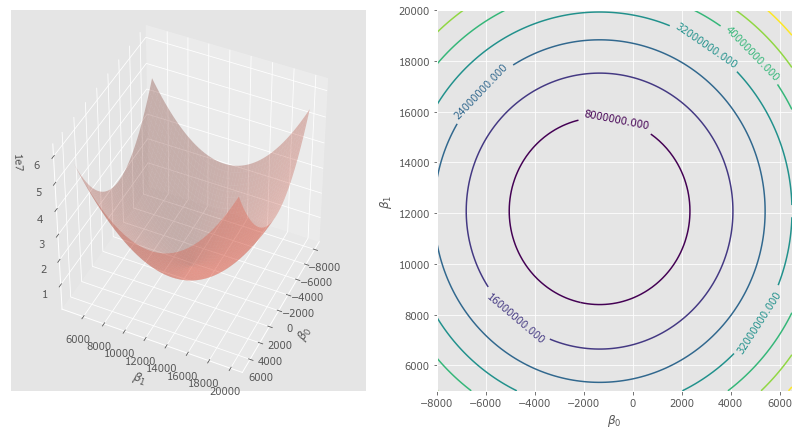

In [8]:
sq_loss_demo()

Посчитаем, чему равен градиент функции потерь $L(\beta_0, \beta_1):$
$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)}$$

Иногда проще это записать в виде матриц:
$$ \frac{\partial L}{\partial \beta} = \frac{1}{n} X^\top(X\beta - y)$$

Метод градиентного спуска заключается в итеративном и **одновременном(!!!)** обновлении значений $\beta$ в направлении, противоположному градиенту:
$$ \beta := \beta - \alpha\frac{\partial L}{\partial \beta}$$

* $\alpha$ -  скорость спуска


## Псевдокод алгоритма

```{python}
1.function gd(X, alpha, epsilon):

2. 	initialise beta 

3. 	do: 

4.      Beta = new_beta

5.      new_Beta = Beta - alpha*grad(X, beta)

6.	until dist(new_beta, beta) < epsilon

7.	return beta
```

In [4]:
from sklearn.utils import shuffle

def grad_demo(iters=1, alpha=0.001):
    
    beta0 = np.linspace(-5000, 2500, 100)
    beta1 = np.linspace(5000, 20000, 100)

    x = df_auto.loc[:, ['mileage']]
    x = (x-x.mean(axis=0))/x.std(axis=0)
    y = df_auto.loc[:, 'price'].values
    X = np.c_[x, np.ones(df_auto.shape[0])]


    B0, B1 = np.meshgrid(beta0, beta1)
    L = ((X.dot(np.r_[B0.reshape(1,-1), B1.reshape(1,-1)]) - y.reshape(-1,1))**2).sum(axis=0)/(2*df_auto.shape[0])

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(X[:,0], y)
    
    Beta, costs, Betas = gradient_descent_upd(X, y, alpha, tol=10**-3, max_iter=iters)
    Betas = np.c_[Betas]
    
    X_1 = np.sort(X, axis=0)
    
    y_hat = X_1.dot(Betas.T)
    
    plt.plot(X_1[:,0], y_hat)
    ax = fig.add_subplot(1, 2, 2)
    contour = ax.contour(B0, B1, L.reshape(B0.shape),)
    plt.clabel(contour, inline=1, fontsize=10)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    
    ax.plot(Betas[:,0], Betas[:, 1], '*-')
    
    plt.show()
    
    
def stoch_grad_demo(iters=1, alpha=0.001):
    
    beta0 = np.linspace(-8000, 5500, 100)
    beta1 = np.linspace(5000, 20000, 100)

    x = df_auto.loc[:, ['mileage']]
    x = (x-x.mean(axis=0))/x.std(axis=0)
    y = df_auto.loc[:, 'price'].values
    X = np.c_[x, np.ones(df_auto.shape[0])]


    B0, B1 = np.meshgrid(beta0, beta1)
    L = ((X.dot(np.r_[B0.reshape(1,-1), B1.reshape(1,-1)]) - y.reshape(-1,1))**2).sum(axis=0)/(2*df_auto.shape[0])

    fig = plt.figure(figsize=(14, 7))    
    Beta, costs, Betas = gradient_descent_upd(X, y, alpha, tol=10**-3, max_iter=iters)
    Betas = np.c_[Betas]
    
    _, _, Betas_stoch = stoch_gradient_descent(X, y, alpha, max_iter=iters)
    Betas_stoch = np.c_[Betas_stoch]
    
    X_1 = np.sort(X, axis=0)
    
    y_hat = X_1.dot(Betas.T)
    ax = fig.add_subplot(1, 1, 1)
    contour = ax.contour(B0, B1, L.reshape(B0.shape),)
    plt.clabel(contour, inline=1, fontsize=10)
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    
    ax.plot(Betas[:,0], Betas[:, 1], '*-')
    ax.plot(Betas_stoch[:,0], Betas_stoch[:, 1], 'o-', c='b')
    plt.axis('equal')
    
    plt.show()
    

def gradient_descent_upd(X, y, alpha, tol=10**-3, max_iter=10):
    n = y.shape[0]
    Beta = np.array([-4000, 6000])
    delta = 10
    cost_prev = 0
    i = 0
    
    # for logging
    Betas = [Beta]
    costs = []
    
    while (delta > tol) and (i <= max_iter):
        y_hat = X.dot(Beta)
        
        # считаем ошибку и значение функции потерь
        error = (y_hat - y)
        cost = np.sum(error ** 2)/float(2 * n)
        delta = abs(cost - cost_prev)
        cost_prev = cost
        
        # считаем градиент
        grad = X.T.dot(error) / n

        # обновляем коэффициенты
        Beta = Beta - alpha * grad
        
        # logging
        if i % 5 == 0:
            costs.append(cost)
            Betas.append(Beta)
        i += 1
        
    return Beta, costs, Betas


def stoch_gradient_descent(X, y, alpha, max_iter=10):
    n = y.shape[0] 
    Beta = np.array([-4000, 6000])
    
    costs = []
    Betas = [Beta]
    
    for i in xrange(max_iter):
        
        X, y = shuffle(X, y, random_state=10)
        
        for j in range(n):
            
            y_hat = X[j].dot(Beta)

            # считаем ошибку и значение функции потерь
            error = y_hat - y[j]

            # считаем градиент
            gradient = X[j].T.dot(error)

            # обновляем коэффициенты
            Beta = Beta - alpha * gradient  # update
            alpha *= 0.99
                # logging
            if j % 5 == 0 and i % 5 == 0:
                Betas.append(Beta)
        
        cost_epoch = np.sum((X.dot(Beta) - y)**2 / (2*n))
        costs.append(cost_epoch)
        
        
    return Beta, costs, Betas

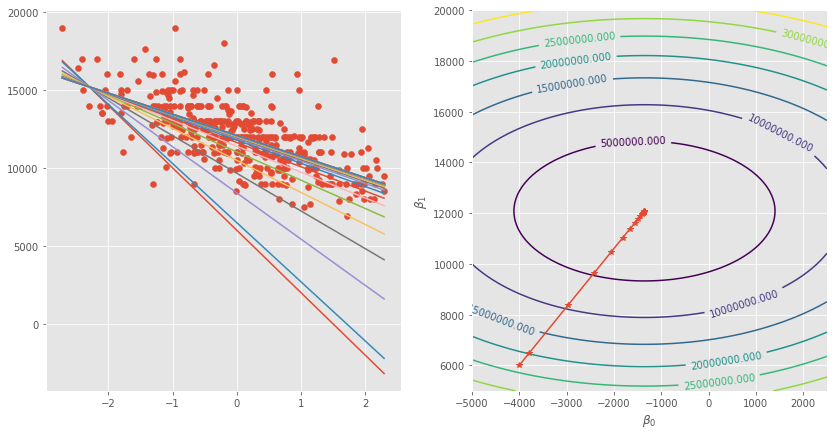

In [5]:
grad_demo(iters=105, alpha=0.08)

## Нюансы

* Как ставить $\alpha$
* Шкала признаков играет роль
<center><img src="http://sebastianruder.com/content/images/2015/12/without_momentum.gif"></center>
* Локальные экстремумы*

## Нюансы

* Надо подбирать $\alpha$
* Влияние шкал признаков
* Попадание в локальный минимум*

## Вариации градиентного спуска
* Стохастический градиентрый спуск (!)
* Градиентный спуск с адаптивной скоростью $\alpha$
* Корректировка на импульс
* ...

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e"><img src='http://sebastianruder.com/content/images/2016/09/contours_evaluation_optimizers.gif'></th>
    <th class="tg-031e"><img src='http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif'></th>
  </tr>
</table>

[Обзор методов 1](http://sebastianruder.com/optimizing-gradient-descent/), [обзор 2](https://medium.com/towards-data-science/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f)

## Стохастический градиентный спуск

```{python}
1.function sgd(X, alpha, epsilon):

2. 	initialise beta 

3. 	do: 

4.        X = shuffle(X)

5.        for x in X:

6.            Beta = new_beta

7.            new_Beta = Beta - alpha*grad(x, beta)

8.	until dist(new_beta, beta) < epsilon

9.	return beta
```

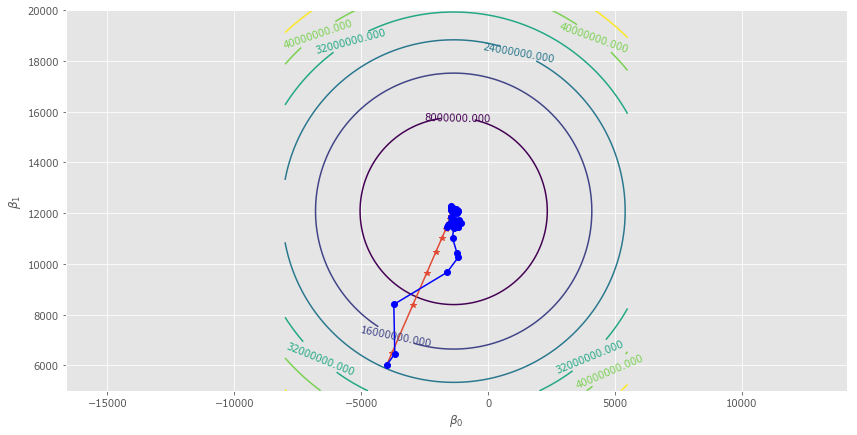

In [11]:
stoch_grad_demo(iters=105, alpha=0.08)

### Momentum

Идея: двигаться не только в направлении текущего градиента, но и немного в направлении предыдущего

$$ v_t = \gamma v_{t - 1} + \alpha\nabla_{\beta}{L(\beta)}$$
$$ \beta = \beta - v_t$$

where
* $\gamma$ — сила импульса (обычно 0.9)
 


### Adagrad 

Идея: Обновлять веса $\beta_i$ для каждого признака по-своему

Обозначим $\frac{\partial L}{\partial\beta_i}$ на шаге $t$ как $g_{t,i}$

В стандартном градиентном спуске

$$ \beta_{t+1, i} = \beta_{t, i} - \alpha \cdot g_{t,i}$$

В Adagrad $\alpha$ нормализуется на "длину" предыдущего шага:

$$ \beta_{t+1, i} = \beta_{t, i} - \dfrac{\alpha}{\sqrt{G_{t,i} + \varepsilon}} \cdot g_{t,i}$$

где $G_{t,i}$ сумма квадратов $g_{t,i}$ до шага $t$. $\varepsilon$ — сглаживающий коэффициент

## Так же есть
* Методы 0-го порядка
    * Покоординатный спуск
* Методы 2-го порядка
    * Ньютоновские методы

# Основные факторы

## Переобучение\недообучение

<center><img src=http://www.holehouse.org/mlclass/10_Advice_for_applying_machine_learning_files/Image%20[8].png></center>
[Andrew's Ng Machine Learning Class - Stanford]

## Мультиколлинеарность

**Мультиколлинеарность** - эффект при котором, подмножество предикторов являются (почти) линейно зависимыми (коэффициент корреляции по модулю близок к 1). Из-за этого:

* Матрица $X^{\top} X$ становится плохо обусловленной или необратимой
* Зависимость $y = \beta_0 + \beta_1x_1 + \beta_2x_2$ перестаёт быть одназначной

С этим эффектом можно бороться несколькими способами

* Последовательно добавлять переменные в модель
* Исключать коррелируемые предикторы

### Регуляризация

В обоих случаях может помочь **регуляризация** - добавление штрафного слагаемого за сложность модели в функцию потерь. В случае линейной регрессии было:
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(a(x^{(i)}) - y^{(i)})^2 $$
Стало (Ridge Regularization)
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\left[ \sum^{n}_{i=1}(a(x^{(i)}) - y^{(i)})^2\right] + \frac{1}{C}\sum_{j=1}^{m}\beta_j^2$$
или (Lasso Regularization)
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\left[ \sum^{n}_{i=1}(a(x^{(i)})  - y^{(i)})^2\right] + \frac{1}{C}\sum_{j=1}^{m}|\beta_j| $$


<center><img src=images/regul.jpg></center>


### Природа зависимости

Далеко не всегда переменные зависят друг от друга именно в том виде, в котором они даны. Никто не запрещает зависимость вида
$$\log(y) = \beta_0 + \beta_1\log(x_1)$$
или
$$y = \beta_0 + \beta_1\frac{1}{x_1}$$
или
$$y = \beta_0 + \beta_1\log(x_1)$$
или
$$y = \beta_0 + \beta_1 x_1^2 + \beta_2 x_2^2 + \beta_3 x_1x_2 $$
и т.д.

Не смотря на то, что могут возникать какие-то нелинейные функции - всё это сводится к **линейной** регрессии (например, о втором пункте, произведите замену $z_1 = \frac{1}{x_1}$)

In [12]:
def demo_weights():
    df = pd.read_csv('data/weights.csv', sep=';', index_col=0)
    
    fig, ax = plt.subplots(1,2)
    
    df.plot(x = 'body_w', y='brain_w', kind='scatter', ax=ax[0])
    for k, v in df.iterrows():
        ax[0].annotate(k, v[:2])
    # Должно получится что-то несуразное..
    
    df['log_body_w'] = np.log(df.body_w)
    df['log_brain_w'] = np.log(df.brain_w)
    df.plot(x = 'log_body_w', y='log_brain_w', kind='scatter', ax=ax[1])
    for k, v in df.iterrows():
        ax[1].annotate(k, v[2:])
        
    plt.show()

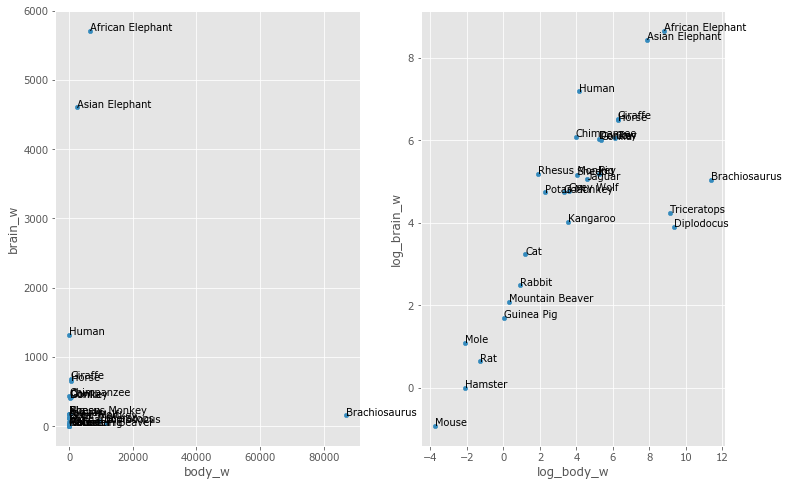

In [13]:
demo_weights()

# Логистическая  регрессия

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png'></center>

Нам надо найти уравнение прямой (гиперплоскости), которая бы могла разделить два класса ($H_2$ и $H_3$ подходят). В данном случае, уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = \langle w, x \rangle + w_0 =  w^\top x + w_0$$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'} = +1$
* Если $g(x^*) < 0$, то $y^* = \text{'белый'} = -1$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{w_0}{||w||}$ - расстояние от начала координат то прямой
* $\frac{|g(x)|}{||w||}$ - расстояние от точки $x$ до гиперплоскости, степень "уверенности" в классификациий
* Величину $M_i = y^{(i)} \cdot g(x^{(i)})$ называют **отступом**(margin)

Если для какого-то объекта $M_i \geq 0$, то его классификация выполнена успешно.

Отлично! Значит нам надо просто минимизировать ошибки классификации для всех объектов:

$$L(w) = \sum_i [y^{(i)} g(x^{(i)}) < 0] \rightarrow \min_w$$


Проблема в том, что это будет комбинаторная оптимизация. Существуют различные аппроксимации этой функции ошибок:
<center><img src='http://jaquesgrobler.github.io/Online-Scikit-Learn-stat-tut/_images/plot_sgd_loss_functions_11.png'></center>

In [6]:
def demo_sigmoid():
    z = np.linspace(-10, 10, 100)

    y = sigmoid(z)
    plt.plot(z, y)
    plt.xlabel('$z$')
    plt.ylabel('$\sigma(z)$')

Перед тем как мы начнем, рассмотрим функцию $$\sigma(z) = \frac{1}{1 + exp{(-z)}},$$она называется **сигмойда**. 

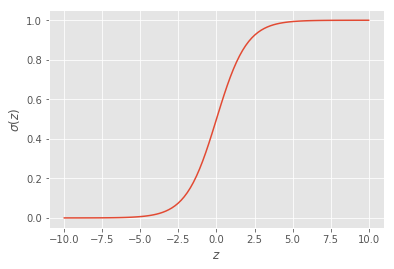

In [7]:
def sigmoid(z): 
    return 1./(1+np.exp(-z))
demo_sigmoid() 

<center><img src='images/prob.png' width=600></center>

#### Постановка задачи
Будем требовать, чтобы алгоритм возвращал вероятность класса $y=+1$:
$$h(x,w) = p(y=+1|x,w) = \sigma(g(x))$$

Выпишем функцию правдоподобия
$$ \mathcal{L}(w) = \prod_i^n h(x^{(i)},w)^{[y^{(i)} = +1]} (1 - h(x^{(i)},w))^{[y^{(i)} = -1]} \rightarrow \max_w$$
$$ -\log{\mathcal{L}(w)} = - \sum_i^n [y^{(i)} = +1]\cdot\log{(h(x^{(i)},w))} + {[y^{(i)} = -1]}\cdot\log{(1-h(x^{(i)},w))} \rightarrow \min_w$$
$$L(w) = \log{\mathcal{L}(w)} \rightarrow \min_w $$

Рассмотрим объекты со следующими признаками:

| x1 | x2 |
|---|---|
| 0 | 1 |
| 1 | 0 |
| 1 | 1 |
| 2 | 2 |
| 2 | 3 |
| 3 | 2 |

Определите к какому классу относятся наблюдения, если вектор параметров имеет вид $(w_0 = -0.3 , w_1 = 0.1, w_2 = 0.1)$

In [8]:
X = np.array([[0,1],[1,0],[1,1],[2,2],[2,3],[3,2]]) 
w = np.array([.1, .1])
w0 = -.3


#### Другая постановка
Можно несколькими способами представить логистическую регрессию:

Рассмотрим принадлежность к классу $y=\pm1$ некого объекта $x$: 
$$p(y=\pm1 | x,w)$$ и выразим её через **сигмойду** от **отступа**:

$$p(y=\pm1|x,w) = \sigma(y (\langle w, x \rangle + w_0)) = \sigma(y^{(i)} g(x^{(i)}))$$

А ошибка, которую мы будем минимизировать - логарифмическая:

$$L(w) = - \frac{1}{N}\sum_i \log(\sigma(y^{(i)} g(x^{(i)})) = \frac{1}{N}\sum_i \log(1 + e^{-y^{(i)} g(x^{(i)})}) \rightarrow \min_w$$

<center><img src='images/overfitting.jpg'></center>
* Как искать $w$? - c помощью градиентного спуска!
* А что с регуляризацией? - та же история 
    * Lasso: $ \frac{1}{C} \sum\limits_{j=1}^d |w_j|$
    * Rigde: $ \frac{1}{C} \sum\limits_{j=1}^d w_j^2$

## Многоклассовая классификация

* А если классов несколько?
    * 1-vs-1
    * 1-vs-rest
    * Softmax 

## Softmax

Для каждого класса определяется свой набор весов
$$
\begin{cases}
g_1(x)=w_{1}^{T}x + w_{0,1} \\
g_{2}(x)=w_{2}^{T}x + w_{0,2}\\
\cdots\\
g_{C}(x)=w_{C}^{T}x + + w_{0,C}
\end{cases}
$$

Нормировка "скоров" классов

$$
p(y=c|x)=softmax(g_c|W, x)=\frac{exp(w_{c}^{T}x + w_{0,c})}{\sum_{i}exp(w_{i}^{T}x + w_{0,i})}
$$


# Доп. Материалы
* Christopher M. Bishop. Pattern Recognition and Machine Learning. Ch3 and Ch4
* Trevor Hastie, et al. The Elements of Statistical Learning. Ch3 and Ch4

## Вопросы?

## Оставьте, пожалуйста, свой отзыв